In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import ipywidgets as widgets
from IPython.display import display

# MDP class

In [20]:
class MDP:
    """A Markov Decision Process, defined by an initial state, transition model,
    and reward function. We also keep track of a gamma value, for use by
    algorithms. The transition model is represented somewhat differently from
    the text. Instead of P(s' | s, a) being a probability number for each
    state/state/action triplet, we instead have T(s, a) return a
    list of (p, s') pairs. We also keep track of the possible states,
    terminal states, and actions for each state. [Page 646]"""

    def __init__(self, start_state, actions_list,
                 terminals, transitions, reward, gamma=0.9):
        if not (0 < gamma <= 1):
            raise ValueError("An MDP must have 0 < gamma <= 1")

        self.start_state = start_state
        self.actions_list = actions_list
        self.terminals = terminals
        self.transitions = transitions
        self.reward = reward
        self.gamma = gamma

    def R(self, state):
        """Return a numeric reward for this state."""
        return self.reward[state]

    def T(self, state, action):
        """Transition model. From a state and an action, return a list
        of (probability, result-state) pairs."""
        return self.transitions[state][action]

    def actions(self, state):
        """Return a list of actions that can be performed in this state. By default, a
        fixed list of actions, except for terminal states. Override this
        method if you need to specialize by state."""

        if state in self.terminals:
            return [None]
        else:
            return self.actions_list



In [21]:
orientations = FORWARD, RIGHT, UP, BACKWARD, LEFT, DOWN = [(1, 0, 0),
                                                           (0, 1, 0),
                                                           (0, 0, 1),
                                                           (-1, 0, 0),
                                                           (0, -1, 0),
                                                           (0, 0, -1)]

In [22]:
# Function to rotate a vector
def rotate_vector(vector, axis, angle_degree):
    if isinstance(vector, tuple):
        vector = np.array(vector)
    angle_rad = np.radians(angle_degree)
    # Rotation matrix around the x-axis
    if axis == 'x':
        rot_matrix = np.array([
            [1, 0, 0],
            [0, np.cos(angle_rad), -np.sin(angle_rad)],
            [0, np.sin(angle_rad), np.cos(angle_rad)]
        ])
    # Rotation matrix around the y-axis
    elif axis == 'y':
        rot_matrix = np.array([
            [np.cos(angle_rad), 0, np.sin(angle_rad)],
            [0, 1, 0],
            [-np.sin(angle_rad), 0, np.cos(angle_rad)]
        ])
    # Rotation matrix around the z-axis
    elif axis == 'z':
        rot_matrix = np.array([
            [np.cos(angle_rad), -np.sin(angle_rad), 0],
            [np.sin(angle_rad), np.cos(angle_rad), 0],
            [0, 0, 1]
        ])
    else:
        raise ValueError('Axis must be either x or y, or z')
    # Apply the rotation
    result = np.dot(rot_matrix, vector)
    return np.round(result).astype(int)

In [23]:
def keep_forward(vector):
    return np.array(vector)


def turn_left(vector):
    # Rotate -90 degrees around the z-axis
    return rotate_vector(vector, 'z', -90)


def turn_right(vector):
    # Rotate 90 degrees around the z-axis
    return rotate_vector(vector, 'z', 90)


def turn_up(vector):
    # Rotate -90 degrees around the y-axis
    return rotate_vector(vector, 'y', -90)


def turn_down(vector):
    # Rotate 90 degrees around the y-axis
    return rotate_vector(vector, 'y', 90)


def turn_backward(vector):
    # Rotate 180 degrees around the y-axis
    return -np.array(vector)

In [24]:
def get_action_distribution(forward_prob, dim=3):
    if not (dim == 2 or dim == 3):
        raise ValueError("Dimension must be 2 or 3")
    distributions = [(forward_prob, keep_forward)]
    turn_actions = [turn_up, turn_down, turn_backward]
    if dim == 3:
        turn_actions += [turn_left, turn_right]

    complement_prob = 1 - forward_prob
    distributions.extend(((complement_prob / len(turn_actions), action) for action in turn_actions))
    return distributions

In [57]:
class GridMDP(MDP):

    def __init__(self, start_state, grid, action_distribution, terminals, gamma=.9):
        # grid.reverse()  # because we want row 0 on bottom, not on top
        reward = dict()
        self.states = set()
        # states = set()
        self.rows = len(grid)
        self.cols = len(grid[0])
        y = 0
        for x in range(self.cols):
            for z in range(self.rows):
                self.states.add((x, y, z))
                reward[(x, y, z)] = grid[z][x]

        actions_list = [FORWARD, UP, DOWN, BACKWARD]
        self.action_distribution = action_distribution
        terminals = [(col, 0, row) for (row, col) in terminals]

        transitions = dict()
        for s in self.states:
            transitions[s] = dict()
            for a in actions_list:
                transitions[s][a] = self.calculate_T(s, a)
        super().__init__(start_state=start_state, actions_list=actions_list,
                         terminals=terminals, transitions=transitions,
                         reward=reward, gamma=gamma)

    def calculate_T(self, state, action):
        return [(prob, self.go(state, transform(action))) for prob, transform in self.action_distribution]

    def T(self, state, action):
        return self.transitions[state][action] if action else [(0.0, state)]

    def go(self, state, direction):
        """Return the state that results from going in this direction."""
        if isinstance(direction, tuple):
            direction = np.array(direction)
        if isinstance(state, tuple):
            state = np.array(state)
        go_state = tuple(state + direction)
        return go_state if go_state in self.states else tuple(state)



In [71]:

rewards = [[-0.04, -0.04, -0.04, -1, -1, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -1, -0.04],
           [-0.04, -0.04, -0.04, -1, -1, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -1, -0.04],
           [-0.04, -0.04, -0.04, -0.04, -1, -0.04, -0.04, -0.04, -1, -0.04, -0.04, -0.04, -0.04],
           [-0.04, -0.04, -0.04, -0.04, -1, -0.04, -0.04, -0.04, -1, -0.04, -0.04, -0.04, -0.04],
           [-0.04, -1, -0.04, -0.04, -0.04, -0.04, -0.04, -1, -1, -1, -0.04, -0.04, +1],
           [-0.04, -1, -0.04, -0.04, -0.04, -0.04, -0.04, -1, -1, -1, -0.04, -0.04, -0.04]]

obstacles = [(0, 3), (0, 4), (0, 11), (1, 3), (1, 4), (1, 11), (2, 4), (2, 8), (3, 4), (3, 8), (4, 1), (4, 7), (4, 8),
             (4, 9),(5,1), (5, 7), (5, 8), (5, 9)]
finish = [(4, 12)]
start = [(1, 0)]

In [72]:
grid_mdp = GridMDP(start_state=start, grid=rewards,
                   action_distribution=get_action_distribution(forward_prob=0.8, dim=2),
                   terminals=obstacles + finish, gamma=0.9)

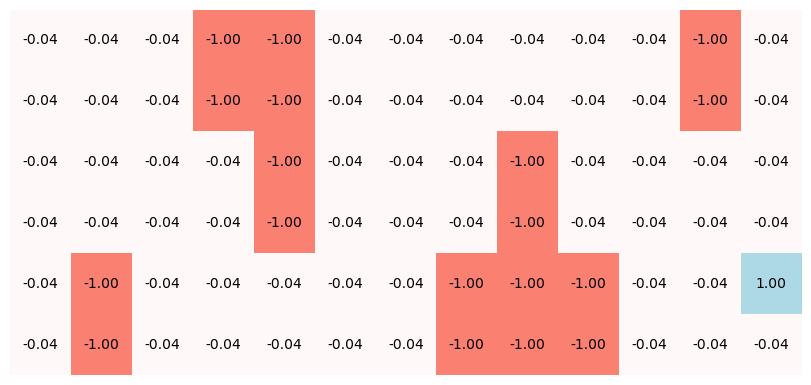

In [68]:
def vis(utility):
    # Define the colors - each entry in the list corresponds to a point in the colormap range
    colors = ["salmon", "white", "lightblue"]
    
    # Create the colormap
    cmap = mcolors.LinearSegmentedColormap.from_list("utility", colors)
    
    fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
    data = utility
    grid = []
    for row in range(grid_mdp.rows):
        current_row = []
        for column in range(grid_mdp.cols):
            current_row.append(data[(column, 0, row)])
        grid.append(current_row)
    im = ax.imshow(grid, cmap=cmap, interpolation='nearest')
    ax.axis('off')
    
    for col in range(len(grid)):
        for row in range(len(grid[0])):
            value = grid[col][row]
            ax.text(row, col, f"{value:.2f}", va='center', ha='center')
            
    fig.patch.set_facecolor('none')
    plt.show()
vis(grid_mdp.reward)

# Value iteration

In [73]:
def value_iteration_instru(mdp, iterations=30):
    U_over_time = []
    U1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    for _ in range(iterations):
        U = U1.copy()
        for s in mdp.states:
            U1[s] = R(s) + gamma * max([sum([p * U[s1] for (p, s1) in T(s, a)])
                                        for a in mdp.actions(s)])
        U_over_time.append(U)
    return U_over_time

vi_result = value_iteration_instru(grid_mdp)


In [64]:
grid_mdp.terminals

[(3, 0, 0),
 (4, 0, 0),
 (11, 0, 0),
 (3, 0, 1),
 (4, 0, 1),
 (11, 0, 1),
 (5, 0, 2),
 (9, 0, 2),
 (5, 0, 3),
 (9, 0, 3),
 (1, 0, 4),
 (7, 0, 4),
 (8, 0, 4),
 (9, 0, 4),
 (7, 0, 5),
 (8, 0, 5),
 (9, 0, 5),
 (12, 0, 4)]

In [41]:
vi_result

list

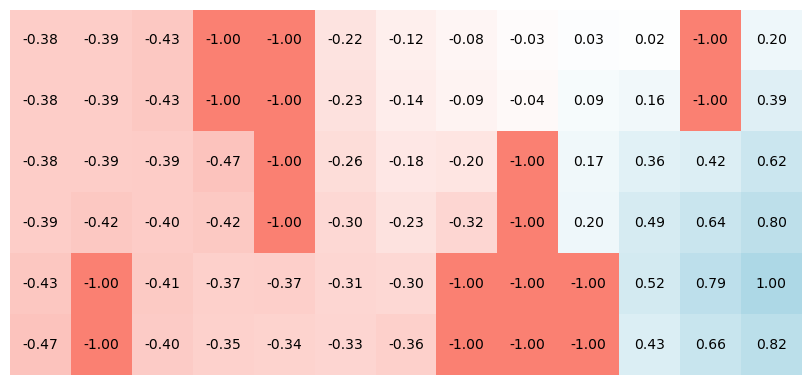

In [75]:
vis(vi_result[29])

In [195]:
value_iteration_instru(grid_mdp)

TypeError: unhashable type: 'numpy.ndarray'

# Policy iteration

# 2D

# 3D